## Day 23 Boundaries

### Data

- NaturalEarth Countries

In [44]:
import geopandas as gpd

earth_df = gpd.read_file(
        gpd.datasets.get_path('naturalearth_lowres')
    )

In [45]:
bboxes = earth_df.bounds

In [46]:
bboxes.head(3)

,minx,miny,maxx,maxy
0,-180.000000,-18.287990,180.000000,-16.020882
1,29.339998,-11.720938,40.316590,-0.950000
2,-17.063423,20.999752,-8.665124,27.656426


In [47]:
from shapely.geometry import box, shape, Polygon

# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
# Makes a rectangular polygon from the provided bounding box values, with counter-clockwise order by default.

In [48]:
 bboxes['bbox'] = bboxes.apply(lambda row: box(row[0],row[1],row[2],row[3]), axis=1)

In [58]:
import pandas as pd

earth = gpd.GeoDataFrame(pd.concat([earth_df, bboxes], axis=1), geometry='bbox', crs=4326)
earth['pseudo_area'] = earth.area
display(earth.sample(3))


C:\dev\conda3\envs\geopy2020\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,minx,miny,maxx,maxy,bbox,pseudo_area
53,3758571,Africa,Mauritania,MRT,16710.0,"POLYGON ((-17.06342 20.99975, -16.84519 21.333...",-17.063423,14.616834,-4.923337,27.395744,"POLYGON ((-4.92334 14.61683, -4.92334 27.39574...",155.137063
51,14668522,Africa,Senegal,SEN,39720.0,"POLYGON ((-16.71373 13.59496, -17.12611 14.373...",-17.625043,12.332090,-11.467899,16.598264,"POLYGON ((-11.46790 12.33209, -11.46790 16.598...",26.267444
141,62137802,Europe,Italy,ITA,2221000.0,"MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...",6.749955,36.619987,18.480247,47.115393,"POLYGON ((18.48025 36.61999, 18.48025 47.11539...",123.114173


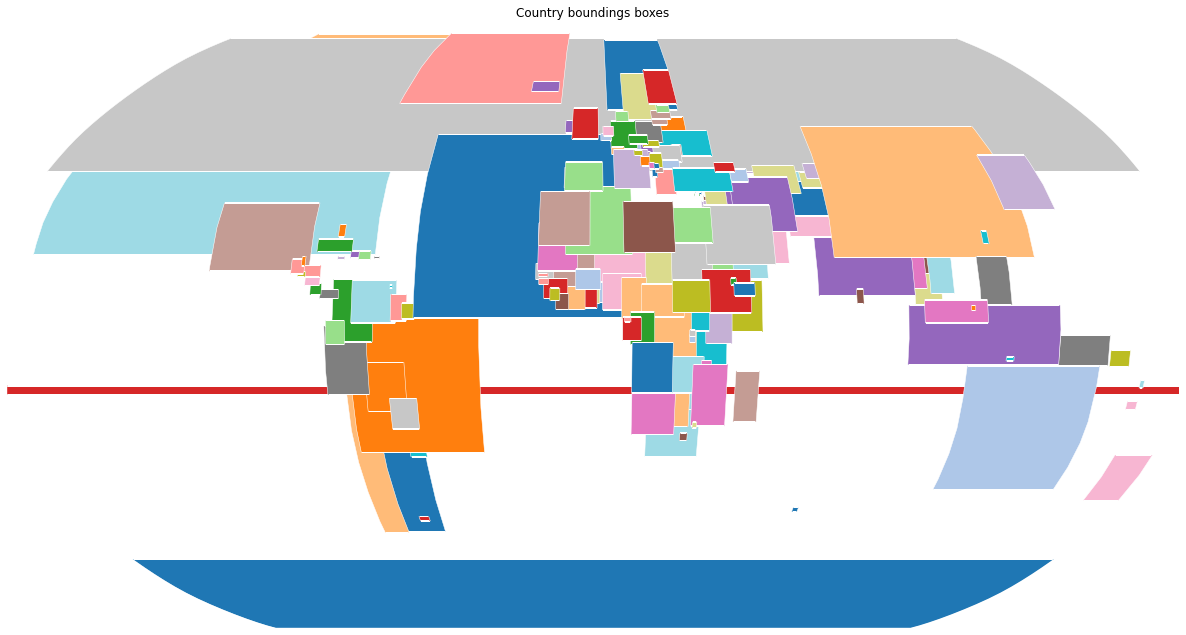

In [59]:
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

gplt.choropleth(
    earth,
    hue='iso_a3',
    
    cmap='tab20', linewidth=0.5,
    edgecolor='white',
    legend=False,
    projection=gcrs.Robinson(),
    figsize=(21,17)
)
plt.title("Country boundings boxes")
# plt.savefig("ny-state-demographics.png", bbox_inches='tight', pad_inches=0.1)

plt.show()

In [60]:
from typing import Union, List
from shapely.geometry import mapping, Polygon, GeometryCollection
from shapely import affinity

# https://towardsdatascience.com/around-the-world-in-80-lines-crossing-the-antimeridian-with-python-and-shapely-c87c9b6e1513
# https://gist.github.com/PawaritL/ec7136c0b718ca65db6df1c33fd1bb11

def check_crossing(lon1: float, lon2: float, validate: bool = True):
    """
    Assuming a minimum travel distance between two provided longitude coordinates,
    checks if the 180th meridian (antimeridian) is crossed.
    """
    if validate and any(abs(x) > 180.0 for x in [lon1, lon2]):
        raise ValueError("longitudes must be in degrees [-180.0, 180.0]")   
    return abs(lon2 - lon1) > 180.0

def check_for_geom(geom):
    crossed = 0
    p_init = geom.exterior.coords[0]

    for p in range(1, len(geom.exterior.coords)):
        px = geom.exterior.coords[p]
        # print(px)

        try:
            if check_crossing(p_init[0], px[0]):
                crossed = 1
        except ValueError:
            crossed = -1
        p_init = px
    
    return crossed

In [61]:
earth['crossed'] = earth['bbox'].apply(check_for_geom)

print(earth['crossed'].value_counts())

 0    174
 1      2
-1      1
Name: crossed, dtype: int64


In [62]:
display(earth.loc[earth['crossed'] != 0])

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,minx,miny,maxx,maxy,bbox,pseudo_area,crossed
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.000 -16.067, 180.000 -16.5...",-180.0,-18.287990,180.0,-16.020882,"POLYGON ((180.000 -18.288, 180.000 -16.021, -1...",816.158788,1
18,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516...",-180.0,41.151416,180.0,81.250400,"POLYGON ((180.000 41.151, 180.000 81.250, -180...",14435.634195,-1
159,4050,Antarctica,Antarctica,ATA,810.0,"MULTIPOLYGON (((-48.661 -78.047, -48.151 -78.0...",-180.0,-90.000000,180.0,-63.270660,"POLYGON ((180.000 -90.000, 180.000 -63.271, -1...",9622.562224,1


In [63]:
earth_c = earth.loc[earth['name'] != "Fiji"]

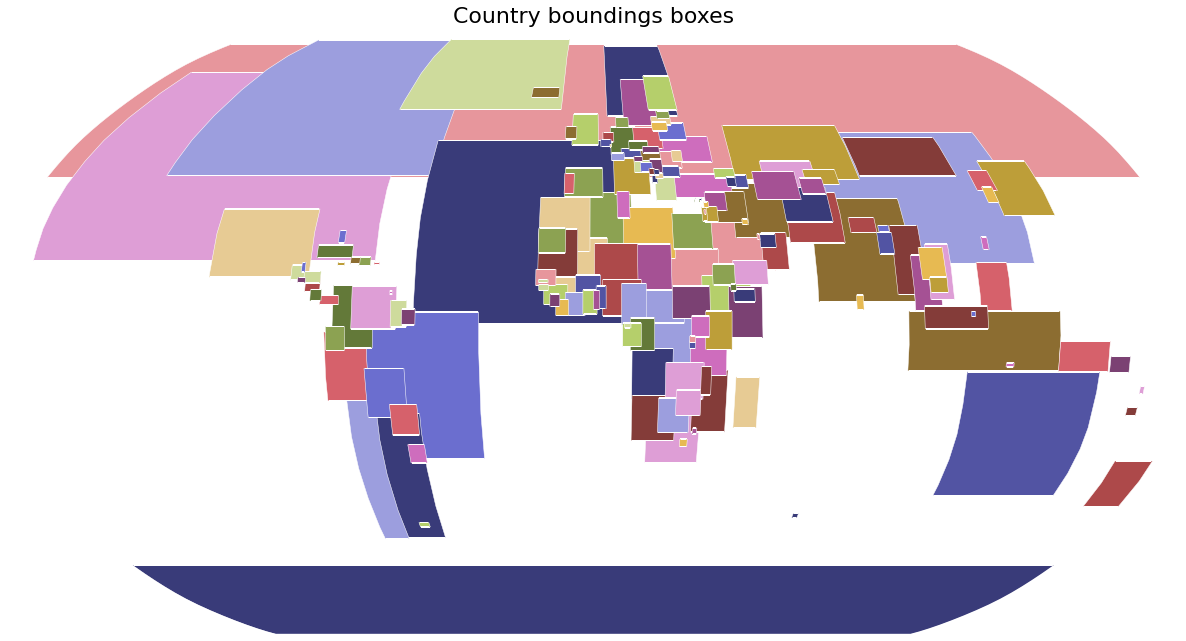

In [66]:
gplt.choropleth(
    earth_c.sort_values(by="pseudo_area", ascending=False).reset_index(),
    hue='iso_a3',
    
    cmap='tab20b', linewidth=0.5,
    edgecolor='white',
    legend=False,
    projection=gcrs.Robinson(),
    figsize=(21,17)
)
plt.title("Country boundings boxes", fontsize=22)
plt.savefig("../source/_static/day-23-boundaries.png", bbox_inches='tight')
plt.show()